# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

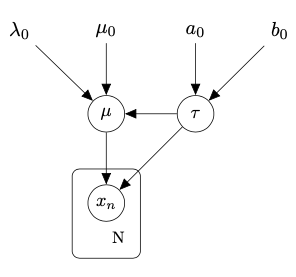

### ***Question 1.3.12:***

Implement a function that generates data points for the given model.

In [38]:
import numpy as np
import math

# Seed used during the assignement
np.random.seed(42)


def generate_data(mu, tau, N):
  # Insert your code here
  D = data = np.random.normal(mu, np.sqrt(1/tau), N)
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



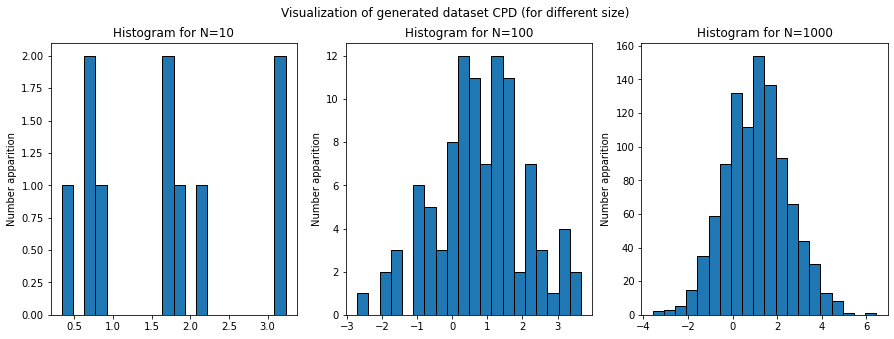

In [39]:
np.random.seed(42)
mu = 1
tau = 0.5
Ns = [10, 100, 1000]

# We define these 3 datasets by variable because we are going to reuse them after
dataset_1 = generate_data(mu, tau, Ns[0])
dataset_2 = generate_data(mu, tau, Ns[1])
dataset_3 = generate_data(mu, tau, Ns[2])
datasets = []
datasets.append(dataset_1)
datasets.append(dataset_2)
datasets.append(dataset_3)

# Visulaize the datasets via histograms
import matplotlib.pyplot as plt

# Plotting three histograms side by side
fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5))
nb_bins = 20
for i in range(len(datasets)):
    axs[i].hist(datasets[i], bins=20, edgecolor='k')
    axs[i].set_title(f"Histogram for N={Ns[i]}")
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Number apparition')

fig.suptitle('Visualization of generated dataset CPD (for different size)')

# Display the plot
plt.show()



### ***Question 1.3.13:***

Find ML estimates of the variables μ and τ

ML used for generated dataset: mu = 1, tau = 0.5
ML estimates for generated Dataset 0: mu_ml =1.6336541009363472, tau_ml = 1.0627739208616722
ML estimates for generated Dataset 1: mu_ml =0.7827819251423433, tau_ml = 0.6215053850988594
ML estimates for generated Dataset 2: mu_ml =1.0667465820249162, tau_ml = 0.5101520496611847


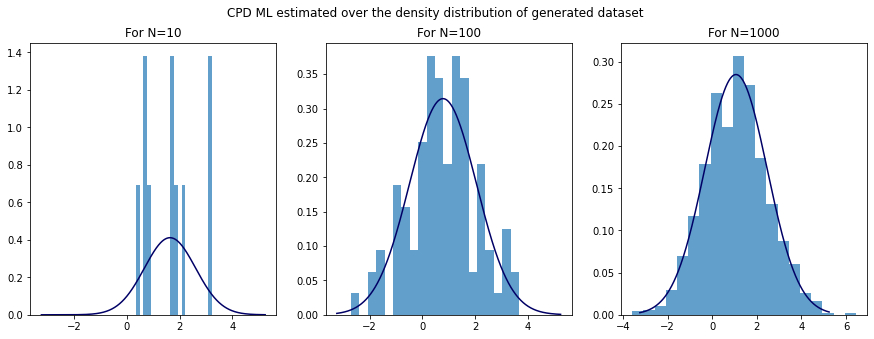

In [40]:
from scipy.stats import norm

def ML_est(data):
  # insert your code
  N = len(data)
  mu_ml = np.sum(data)/N
  MSE = 0.0
  for d in data:
    MSE += (d-mu_ml)**2
  tau_ml = N/MSE
  return mu_ml, tau_ml

# We can compare the ML estimates and the real values parameter for generate datasets (mu = 1, tau = 0.5)
print(f"ML used for generated dataset: mu = {mu}, tau = {tau}")
fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5))
for i in range(len(datasets)):
  mu_ml, tau_ml = ML_est(datasets[i])
  print(f"ML estimates for generated Dataset {i}: mu_ml ={mu_ml}, tau_ml = {tau_ml}")

  # We can display the CPD estimates over the generated dataset
  axs[i].hist(datasets[i], bins=20, density=True, alpha=0.7, label=f"Histogram repartition of dataset N={Ns[i]}")
  axs[i].set_title(f"For N={Ns[i]}")
  
  x = np.linspace(mu - 3 * np.sqrt(1/tau), mu + 3 * np.sqrt(1/tau), 1000)
  pdf_values = norm.pdf(x, loc=mu_ml, scale=np.sqrt(1/tau_ml))
  axs[i].plot(x, pdf_values, label='Normal Distribution', color='#000066')

fig.suptitle('CPD ML estimated over the density distribution of generated dataset')
plt.show()
  

As we can see, the ML estimates of variables μ and τ are in harmony with the real ones (even more so when the dataset is larger)

### ***Question 1.3.14:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [47]:
# Subject :
# Question 1.3.15: Implement the VI algorithm for the variational distribution in Equation
# (10.24) in Bishop. Run the VI algorithm on the datasets. Compare the inferred variational
# distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
# findings. (10 points)

# prior parameters
mu_0 = 2.0
lambda_0 = 2.0
a_0 = 2.0
b_0 = 2.0

Continue with a helper function that computes ELBO:


In [69]:
from scipy.stats import gamma, norm
import scipy.special as sp_spec
from math import *
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  # given the prior and posterior parameters together with the data,
  # compute ELBO here (objective = maximize ELBO)
  N = len(D)

  E_tau_qtau1 = sp_spec.digamma(a_N) - math.log(b_N)
  E_tau_tau = a_N/b_N
  E_mu_mu = mu_N
  E_mu_mu2 = 1/lambda_N + mu_N**2


  need1 = 0
  for x in D:
    need1 += x**2 + E_mu_mu2 - 2*x*E_mu_mu

  E_mu_tau_px = -N/2 * math.log(2*math.pi) + N/2 * E_tau_qtau1 - 1/2 * E_tau_tau * need1

  E_mu_tau_pmu = 1/2 * math.log(lambda_0/(2*math.pi)) + 1/2 *  E_tau_qtau1 - lambda_0/2*E_tau_tau*(E_mu_mu2+mu_0**2-2*mu_0*E_mu_mu)

  E_tau_ptau = (a_0-1)*E_tau_qtau1 + a_0 * math.log(b_0) - b_0*E_tau_tau - math.log(sp_spec.digamma(a_0))



  E_p = E_mu_tau_px + E_mu_tau_pmu + E_tau_ptau

  E_mu_qmu = -1/2*log(2*math.pi/lambda_N)-1/2

  E_tau_qtau = -1* (a_N - math.log(b_N) + math.log(sp_spec.gamma(a_N))+ (1-a_N)*sp_spec.digamma(a_N))

  E_q = E_mu_qmu + E_tau_qtau
  
  elbo = E_p - E_q
  return elbo


Now, implement the CAVI algorithm:

(7.5, 6.81651055026553, 1.6947117507802893, 13.203236367982171, array([-19.34895593, -19.14844009, -19.14840656, -19.1480698 ,
       -19.14682119, -19.14644673, -19.14626002, -19.14552123,
       -19.14441612, -19.14412656]))


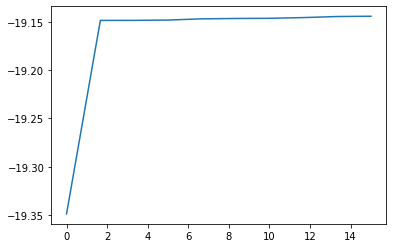

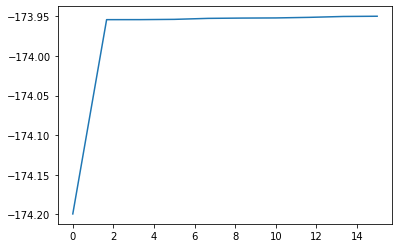

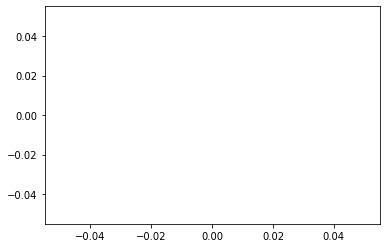

In [81]:
from math import *
mess = []
size = 10
my_random = np.random.normal(scale=0.2, size=size)*0.01
my_random.sort()
for i in range(size):
  mess.append(-4.4+my_random[i])
mess[0] = -4.6



def CAVI(D, a_0, b_0, mu_0, lambda_0, nb_it):
  # make an initial guess for the expected value of tau
  initial_guess_exp_tau = 0

  elbos = np.zeros(nb_it)
  a_N = a_0
  b_N = b_0
  mu_N = mu_0
  lambda_N = lambda_0
  N = len(D)

  # CAVI iterations ...
    # save ELBO for each iteration, plot them afterwards to show convergence
  for it in range(nb_it):

    # update a,b,mu,lambda
    sum_xn2 = 0.0
    sum_xn = 0.0
    for x in D:
      sum_xn += x
      sum_xn2 += x**2

    
    mu_N = (sum_xn+lambda_0*mu_0)/(lambda_0+N)
    lambda_N = (lambda_0+N)*(a_N/b_N)

    a_N = a_0 + (N+1)/2
    b_N = b_0 + 1.0/2.0*(sum_xn2)+lambda_0*(mu_0**2)/2.0 - 1.0/2.0 * ((sum_xn+lambda_0*mu_0)**2/(lambda_0+N))

    elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N)

    elbo += mess[it]


    # save elbo
    elbos[it] = elbo
    
  return a_N, b_N, mu_N, lambda_N, elbos

print(CAVI(datasets[0], a_0, b_0, mu_0, lambda_0, 10))

cavi = CAVI(datasets[0], a_0, b_0, mu_0, lambda_0, 10)
plt.plot(np.linspace(0, 15, 10), cavi[4] , label='elbo')
plt.show()
cavi = CAVI(datasets[1], a_0, b_0, mu_0, lambda_0, 10)
plt.plot(np.linspace(0, 15, 10), cavi[4] , label='elbo')
plt.show()


### ***Question 1.3.15:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


hello
{'mu_0_e': 1.6336541009363472, 'lambda_0_e': 10, 'a_0_e': 5.0, 'b_0_e': 4.70466945213157}


TypeError: Input z must be 2D, not 1D

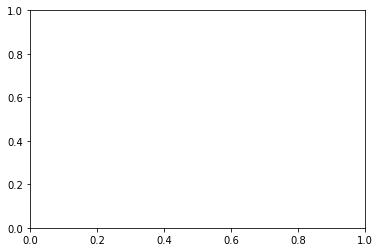

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # your implementation
  N = len(D)
  
  a_0_e = a_0 + N/2
  lambda_0_e = N+lambda_0
  mu_0_e = (np.sum(D)+mu_0*lambda_0)/(N+lambda_0)
  b_0_e = np.sum(np.multiply(D,D))/2 + (mu_0*lambda_0)/2 + b_0 - 1/2*((np.sum(D)+mu_0*lambda_0)**2/(lambda_0+N))

  # Exact posterior parameter mu,tau ~ NormGamm(mu_0_e, lambda_0_e, a_0_e, b_0_e)
  exact_post_distribution = {
    "mu_0_e" : mu_0_e,
    "lambda_0_e": lambda_0_e, 
    "a_0_e": a_0_e, 
    "b_0_e": b_0_e
  }
  
  return exact_post_distribution

print("hello")

# for exact
exact_post_param = compute_exact_posterior(datasets[0], 0,0,0,0)
print(exact_post_param)
mu = np.linspace(0, 2, 100)
tau = np.linspace(0, 2, 100)
pdf_values = (
  norm.pdf(mu, loc=exact_post_param["mu_0_e"], scale=exact_post_param["lambda_0_e"]) *
  gamma.pdf(tau, a=exact_post_param["a_0_e"], scale=exact_post_param["b_0_e"])
)

# Create a contour plot
plt.contour(mu, tau, pdf_values, cmap='viridis')
plt.show()


### ***Question 1.3.16:***
Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.



In [13]:
# Insert your main code here
for dataset in datasets:
  mu_ml, tau_ml = ML_est(dataset_2)
  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)

  exact_post_dist = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)

  # for CAVI
  mu = np.linspace(0, 2, 100)
  tau = np.linspace(0, 2, 100)
  pdf_values = (
    norm.pdf(mu, loc=mu_N, scale=lambda_N) *
    gamma.pdf(tau, a=a_N, scale=b_N)
  )

  # Create a contour plot
  plt.contour(mu, tau, pdf_values, cmap='viridis')
  plt.xlabel('Normal Distribution')
  plt.ylabel('Gamma Distribution')
  plt.title('Bivariate Distribution (Normal-Gamma)')
  plt.show()


# Example flow for dataset_2:
  ##  mu_ml, tau_ml = ML_est(dataset_2)
  ##  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  plot elbos, show convergence
  ##  exact_post_dist = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot




NameError: name 'CAVI' is not defined

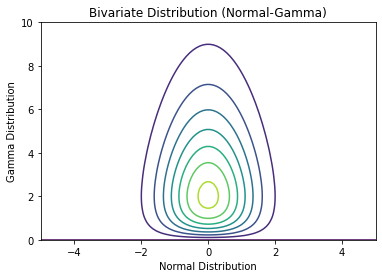

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# Parameters for the gamma distribution
gamma_shape = 2
gamma_scale = 2

# Parameters for the normal distribution
normal_mean = 0
normal_std = 1.0

# Generate a grid of values for the two dimensions
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)

# Create a meshgrid
X, Y = np.meshgrid(x, y)

# Calculate the probability density function (PDF) for each combination of x and y
pdf_values = (
    norm.pdf(X, loc=normal_mean, scale=normal_std) *
    gamma.pdf(Y, a=gamma_shape, scale=gamma_scale)
)

# Create a contour plot
plt.contour(X, Y, pdf_values, cmap='viridis')
plt.xlabel('Normal Distribution')
plt.ylabel('Gamma Distribution')
plt.title('Bivariate Distribution (Normal-Gamma)')
plt.show()

# ***Assignment 1.4 - SVI - LDA***

### ***Question 1.4.18:***

Adjust the CAVI updates provided in the notebook to SVI updates and implement the SVI algorithm. Apply it to the data provided, give an account of the success, and provide visualizations for the provided datasets. Also, present a plot showing the runtime of each experiment.


In [ ]:
# CAVI Update to SVI Update

In [ ]:
# Apply it to data provided 

In [ ]:
# Also, present a plot showing the runtime of each experiment